# Automated Evaluation of Document Understanding Models for Document to JSON

This notebook provides a comprehensive framework for evaluating fine-tuned models that convert document PDFs/Images into structured JSON data. The evaluation includes:

- **Multi-metric assessment** (Exact Match, Character Error Rate, ROUGE)
- **Feature type analysis** (Value Extraction, Classification, Freeform Text)
- **Interactive visualizations**
- **Model performance comparison**

# Setup & Configuration

## Install Required Packages
We use several specialized libraries for evaluation:
- **Levenshtein**: For edit distance calculations
- **plotnine**: For ggplot-style visualizations
- **itables**: Interactive DataFrame display
- **evaluate**: Standard NLP metrics

In [ ]:
%pip install Levenshtein==0.26.1 plotnine==0.14.5 itables==2.2.4 regex==2024.11.6 evaluate==0.4.3 cer==1.2.0 rouge_score==0.1.2 seaborn sagemaker --quiet

## Environment Initialization

* Interactive widget configuration
* Table display settings

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
# Initialization for interactive widgets and table display
from itables import init_notebook_mode, show
import itables.options as opt

opt.columnDefs = [{"width": "100px", "targets": "_all"}]
opt.column_filters = "footer"
opt.showIndex = False
# init_notebook_mode(all_interactive=True)

# Data Processing & Preparation

* Load and parse inference outputs
* Data cleaning and formatting

## Retrieve Inference Results

In [2]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
import os
import boto3
import pandas as pd
from utils.helpers import download_and_extract
import sagemaker

default_bucket = sagemaker.Session().default_bucket()

# Configuration for dataset location
dataset_s3_uri = f"s3://{default_bucket}/fatura2-train-data-300/" #"s3://your-bucket/dataset/"
dataset_base_dir = "./data/processed/"

print("⬇️ Starting download of dataset...")
!aws s3 cp $dataset_s3_uri $dataset_base_dir --recursive --quiet

results_dir = "./data/results"
os.makedirs(results_dir, exist_ok=True)

# Load list of inference runs
# You can modify the csv manually to compare only specific runs or models
inference_runs = pd.read_csv("./results_to_compare.csv")

s3_client = boto3.client("s3")
print("⬇️ Starting download of results...")
inference_runs = inference_runs.progress_apply(
    download_and_extract,
    axis=1,
    output_dir=results_dir,
    s3_client=s3_client,
)


'Extraction completed for infer-json-finetune-llama-3-2-11b-visio-2025-03-17-22-50-45-144'

'✓ Successfully processed row 2 (infer-json-finetune-llama-3-2-11b-visio-2025-03-17-22-50-45-144)'

## Parse Inference Results
Handling potential JSON formatting issues and nested structures:

In [4]:
from tqdm import tqdm
from utils.evaluation import process_run

results_df = []
expected_num_rows = -1
for run in tqdm(inference_runs.itertuples(), desc="Processing files"):
    result_files = run.results_files

    for file in result_files:
        result, num_rows = process_run(run, file, results_dir, expected_num_rows)
        if result is not None:
            results_df.append(result)
            expected_num_rows = num_rows


df_test = pd.concat(results_df)
# show(df_test[["response", "response_raw", "label", "model"]])
df = results_df[-1]

Processing files: 3it [00:00, 22.30it/s]


## View Inference Result Sample

In [5]:
from IPython.display import JSON
# Lets have a look how a sample inference result looks like
JSON(df.iloc[2].to_dict(), root="inference sample")

<IPython.core.display.JSON object>

/opt/conda/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


## Show Diff for Inference and GroundTruth

In [6]:
from utils.docdiff import get_pil_image

# filer_single_model=inference_runs.iloc[-1]["human_name"]
# print(f"We filter for model: {filer_single_model}")
# df_test=df_test[df_test["pretty_name"]==filer_single_model]

df_test["imagePILL"] = df_test[:10].images.map(
    lambda x: get_pil_image(x[0], dataset_base_dir)
)
df_final = df_test[["imagePILL", "response", "labels"]]
# df_final.head()

/tmp/ipykernel_25438/2268319660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["diff"] = df_final.apply(get_diff, axis=1)



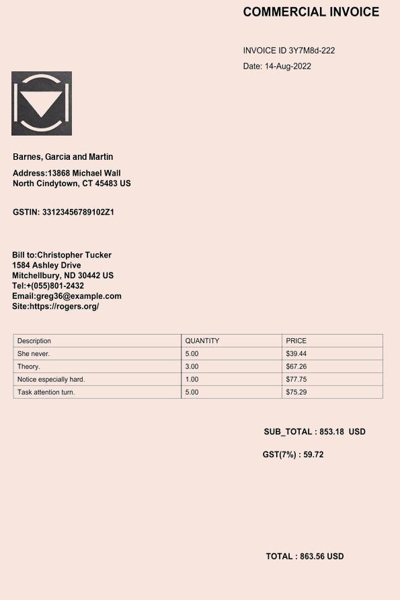
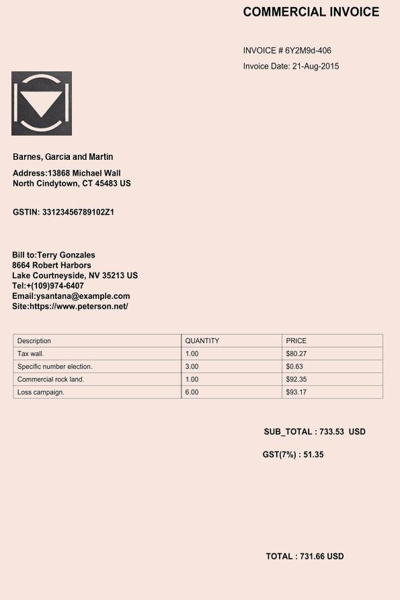
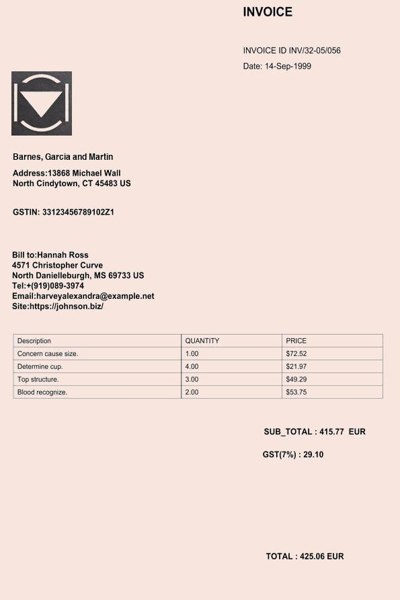
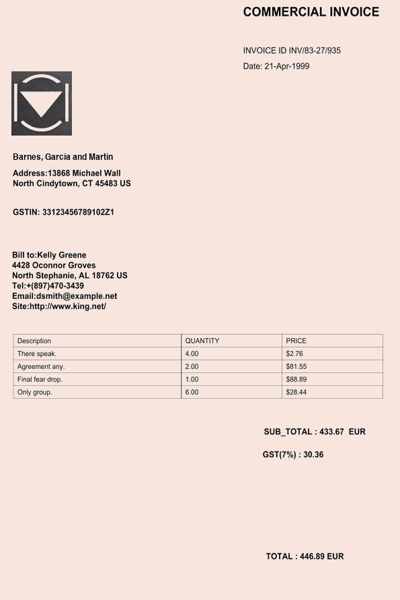
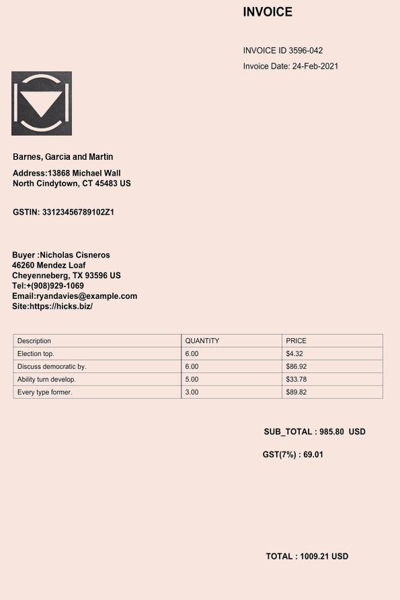
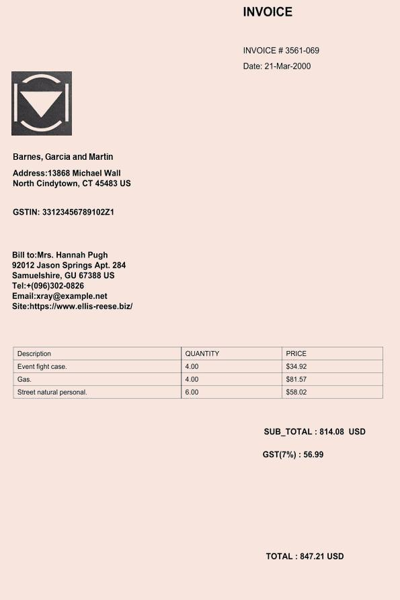
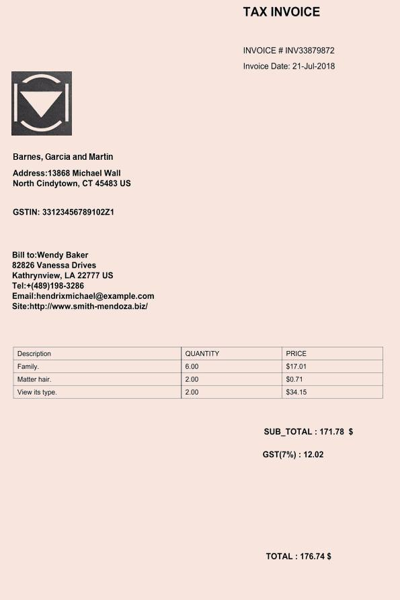
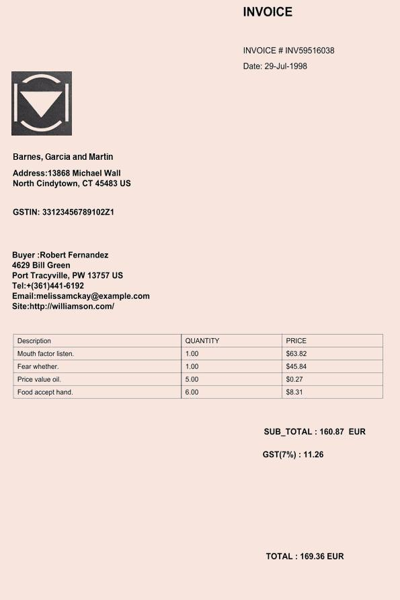
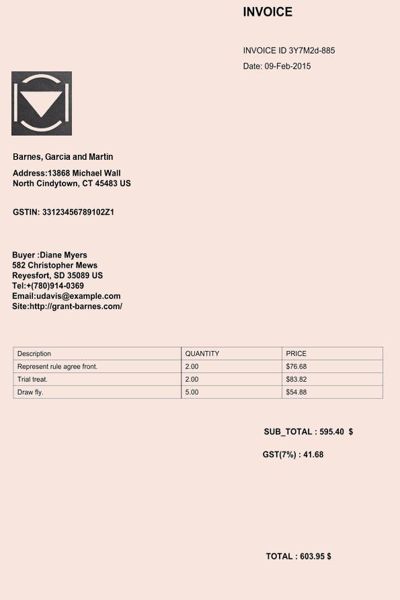
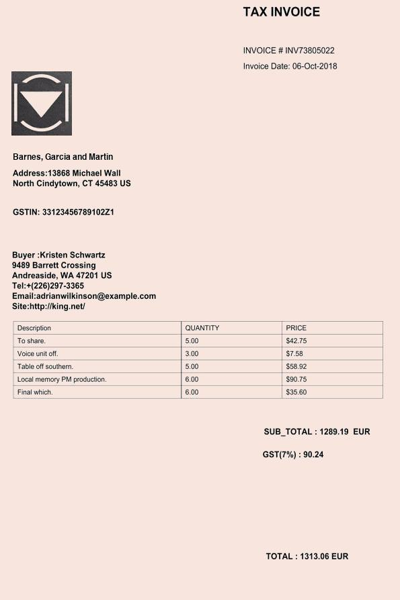

In [7]:
from IPython.display import display, HTML
from utils.docdiff import image_formatter, get_diff

df_final["diff"] = df_final.apply(get_diff, axis=1)
df_final2 = df_final[["imagePILL", "diff"]][0:10]

HTML(df_final2.to_html(formatters={"imagePILL": image_formatter}, escape=False))

## Flatten JSON and Calculate Edit Distance per Entity

In [8]:
from utils.dist import add_edit_distance
# we need to know what attributes are in the destination data structure
columns = df_test["labels"].apply(set).apply(list).explode().drop_duplicates().tolist()
# text_propetry_name = "text"
text_propetry_name = None # if your results only contain the text for each key without a nested structure
df_dist = add_edit_distance(df_test, columns, text_propetry_name)

In [9]:
# edit_cols = list(set(df_dist["labels"].values[0])) # NOTE: we only take the entities from the first label assuming it is complete
melted_df = pd.melt(
    df_dist,
    id_vars=df_test.columns,
    value_vars=columns,
    var_name="entity",
    value_name="dist",
)

In [10]:
from utils.dist import unfold
df_unfold = pd.DataFrame(list(melted_df.apply(unfold, axis=1)))

df_multi = pd.concat([melted_df, df_unfold], axis=1)

In [11]:
model = list(set(df["model"].values))[0]
df_single = df_multi[df_multi["model"] == model]

In [12]:
# show the grountruth outputs for each entity
main_columns = ["fileid","entity","dist","response_val","label_val","model","model_name"]

show(df_single[main_columns][:100],
     classes=['display', 'compact'],
     columnDefs=[
         {"width": "80px", "targets": "_all"},
         {"className": "dt-center", "targets": "_all"}
     ],
     dom='Bfrtip',
     scrollX=False,
     lengthMenu=[5, 10, 25, 50],
     pageLength=10
)


# Feature Type Analysis and Categorization

## Analyse Feature Distribution of Entities

In [13]:
from utils.entities import analyze_string_distribution_by_entity
# Usage
results_df = analyze_string_distribution_by_entity(df_single, col_value="label_val")

# show(results_df,
#      classes=['display', 'compact'],
#      columnDefs=[
#          {"width": "150px", "targets": "_all"},
#          {"className": "dt-center", "targets": "_all"}
#      ],
#      dom='Bfrtip',
#      scrollX=True,
#      lengthMenu=[5, 10, 25, 50],
#      pageLength=10
# )


## Show Entities by Missing GroundTruth

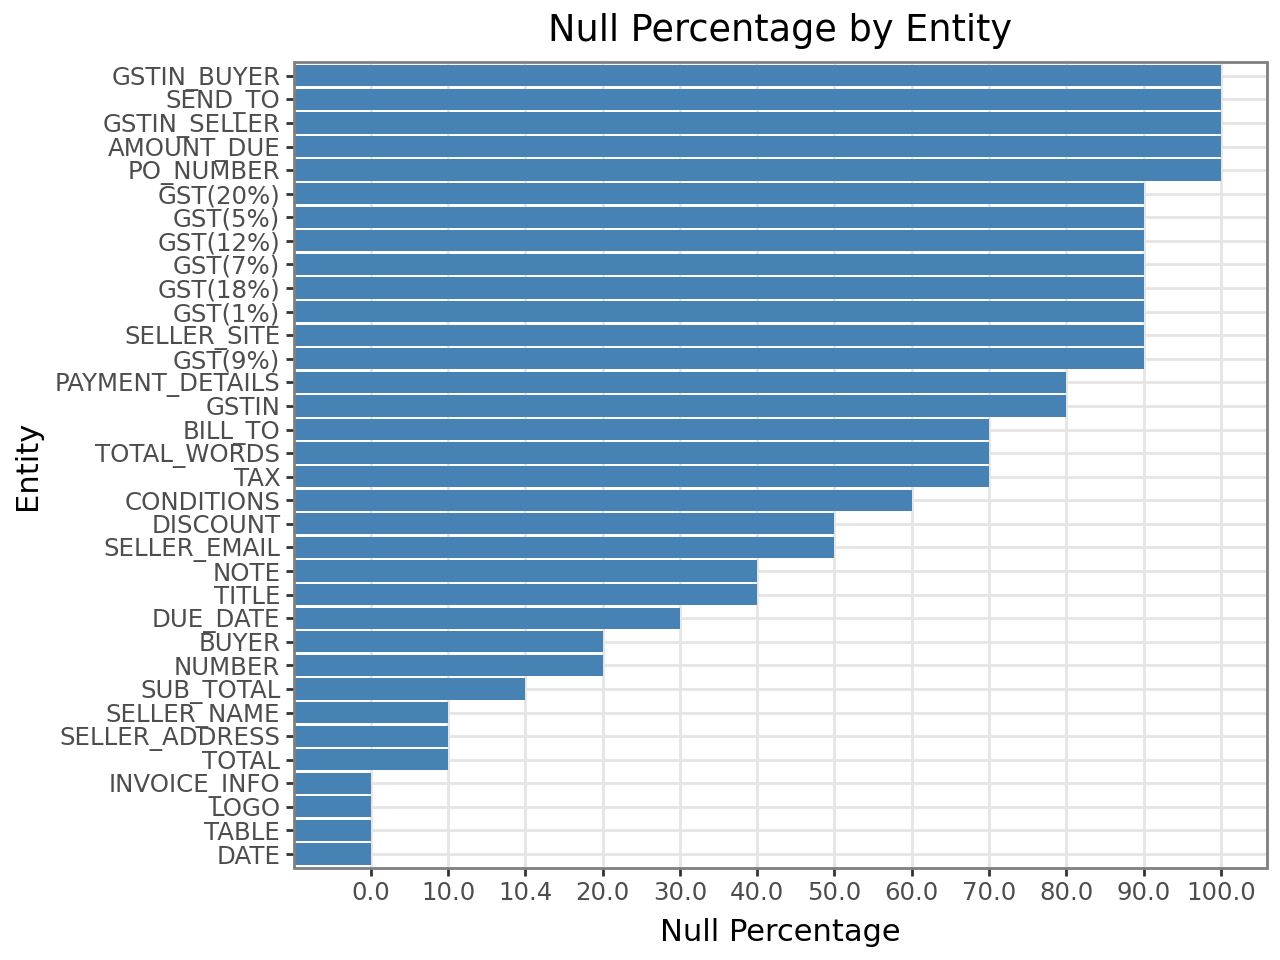

In [14]:
from plotnine import ggplot, aes, geom_bar, theme_minimal, theme_bw,labs, theme, element_text, coord_flip

# Sort the filtered dataframe by metric_value in descending order
plot_data = (results_df[results_df['metric_name'] == 'null_percentage']
             .sort_values('metric_value', ascending=True))  # ascending=True because coord_flip will reverse it

# Create ordered factor for entity based on metric_value
plot_data['entity'] = pd.Categorical(plot_data['entity'], 
                                   categories=plot_data['entity'].tolist(),
                                   ordered=True)

(ggplot(plot_data, 
        aes(x='entity', y='metric_value')) +
 geom_bar(stat='identity', fill='steelblue') +
 coord_flip() +
 labs(title='Null Percentage by Entity',
      x='Entity',
      y='Null Percentage') +
 theme_bw())

We can observe in the plot above, that there are multiple entites, which have more than 60% missing ground truth. GST(20%) has for example 90% missing values.

## Entity String Length Analysis with Boxplots

Lets analyze and categorize entities based on their string lengths using boxplots for visualization.

**Purpose**
- Understand the distribution of entity string lengths
- Classify entities into different categories based on their characteristics
- Establish thresholds for entity classification

**Feature Categorization**

We categorize the entities into three main types:
1. **Missing Ground Truth**: Entities with high null percentage
2. **Short Text**: Entities with shorter length (e.g., dates, amounts)
3. **Long Text**: Entities with longer, free-form text

**Thresholds**
- `null_percentage`: Threshold for identifying missing data (default: 70%)
- `length_mean`: Threshold for distinguishing between short and long text (default: 50 characters)


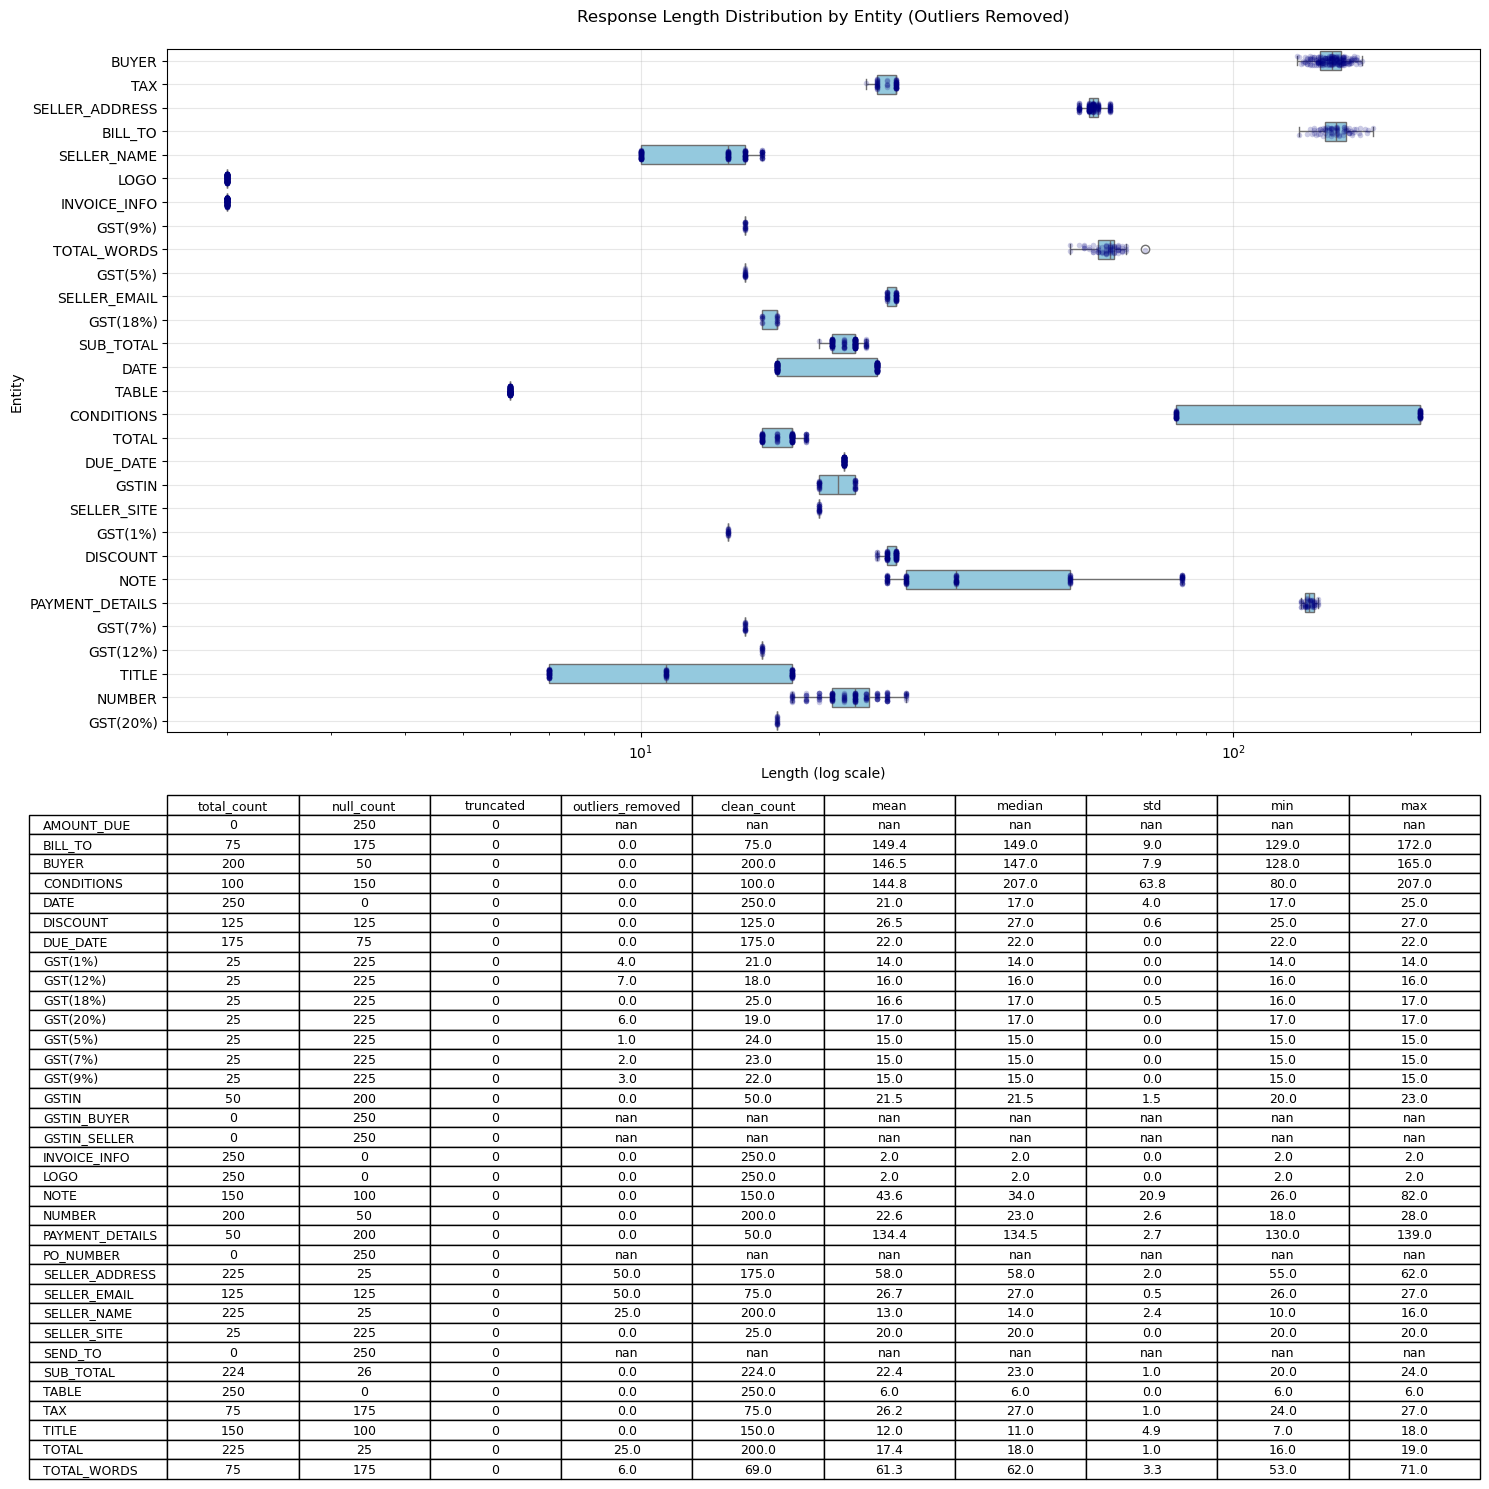

In [15]:
from utils.entities import plot_length_boxplots_with_limits_horizontal

stats_df = plot_length_boxplots_with_limits_horizontal(df_single, col_value="label_val")

In [16]:
from utils.entities import categorize_features
#??categorize_features
feature_categories = categorize_features(results_df, null_percentage_threshold=70, length_mean_threshold=50)

df = pd.DataFrame.from_dict(feature_categories, orient='index', columns=['category'])
grouped = df.groupby('category')
for name, group in grouped:
    print(f"\nGroup: {name}")
    print(group)


Group: LONG_TEXT
                 category
BUYER           LONG_TEXT
SELLER_ADDRESS  LONG_TEXT
BILL_TO         LONG_TEXT
TOTAL_WORDS     LONG_TEXT
CONDITIONS      LONG_TEXT

Group: MISSING_GROUND_TRUTH
                             category
PO_NUMBER        MISSING_GROUND_TRUTH
GST(9%)          MISSING_GROUND_TRUTH
GSTIN_SELLER     MISSING_GROUND_TRUTH
GST(5%)          MISSING_GROUND_TRUTH
GST(18%)         MISSING_GROUND_TRUTH
SEND_TO          MISSING_GROUND_TRUTH
AMOUNT_DUE       MISSING_GROUND_TRUTH
GSTIN            MISSING_GROUND_TRUTH
SELLER_SITE      MISSING_GROUND_TRUTH
GST(1%)          MISSING_GROUND_TRUTH
PAYMENT_DETAILS  MISSING_GROUND_TRUTH
GST(7%)          MISSING_GROUND_TRUTH
GST(12%)         MISSING_GROUND_TRUTH
GSTIN_BUYER      MISSING_GROUND_TRUTH
GST(20%)         MISSING_GROUND_TRUTH

Group: SHORT_TEXT
                category
TAX           SHORT_TEXT
SELLER_NAME   SHORT_TEXT
LOGO          SHORT_TEXT
INVOICE_INFO  SHORT_TEXT
SELLER_EMAIL  SHORT_TEXT
SUB_TOTAL     SHORT_

Next let's display the distribution and values of the features for visual analysis.

# Performance Evaluation for Entities using Edit Distance Heatmap

In [17]:
df = df_multi

In [18]:
df["dist_cut"] = df["dist"].clip(upper=6)
df["dist_cut"] = df["dist_cut"].replace(-2, 7)
df["dist_cut"] = df["dist_cut"].replace(-3, 8)
df["dist_cut"] = df["dist_cut"].replace(-4, 9)
fact_name = sorted(list(set(df["dist_cut"].values)))
mapper = {
    -1: "missing groundtruth",
    0: "exact match",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6+",
    7: "predicted 'None'",
    8: "key missing",
    9: "invalid JSON"
}
rev_map = {value: key for key, value in mapper.items()}
df["dist_cut"] = df["dist_cut"].replace(mapper)
df["dist_cut"] = pd.Categorical(
    df["dist_cut"], categories=mapper.values(), ordered=True
)

In [19]:
# Add a new column 'entity_name' based on the dictionary
df["entity_type"] = df["entity"].map(feature_categories)

In [20]:
df_sorted = df.sort_values(["entity_type", "entity"])

df_entities = df_sorted[["entity", "entity_type"]].drop_duplicates(subset=["entity"])
df_entities.reset_index(inplace=True)

ordered_values = list(df_entities["entity"])
change_indices = df_entities.index[
    df_entities["entity_type"] != df_entities["entity_type"].shift()
].tolist()


# Reorder categories in the dataframe
df_sorted['pretty_name_ordered'] = pd.Categorical(df_sorted['pretty_name'], categories=list(set(df_sorted['pretty_name'].values)), ordered=True)

In [21]:
import pandas as pd
from plotnine import *
from textwrap import fill

def plot_bar_chart_all_entities(df, ordered_values, width=22, height=18, geom_vlines=[2.5, 4.5, 8.5, 10.5]):

    custom_colors = ["#bababa","#66c2a5","#abdda4","#e6f598","#ffffbf","#fee08b","#fdae61","#f46d43","#abd9e9","#74add1","#bebada"]

    def wrap_labels(label):
        return fill(label, width=width+4)  # Wrap text at 15 characters per line
    
    # Create the stacked bar chart
    return (
        ggplot(df, aes(x="entity", fill="factor(dist_cut)"))
        + geom_bar(position="stack", color="black")
        + facet_wrap(" ~pretty_name_ordered", scales="free", labeller=lambda x: wrap_labels(x))
        + labs(x="Entity", y="Count", fill="Char. edit distance")
        + coord_flip()
        + scale_fill_manual(values=custom_colors, labels=mapper)
        + theme_minimal()
        + theme(figure_size=(width, height))
        + geom_vline(
            xintercept=geom_vlines, linetype="dashed", color="#4d4d4d", size=2.2
        )
        + scale_x_discrete(limits=ordered_values)
    )

In [22]:
from IPython.display import Markdown, display

In [23]:
# we want to draw lines in the graphs to distinguish the different entity types
feature_class_lines = [index + 0.5 for index in change_indices[1:]]

In [24]:
pd.set_option('display.max_colwidth', None)

Note: You might need to adjust the width and height below to find a ratio that shows the graphs correctly. 

### All Entities

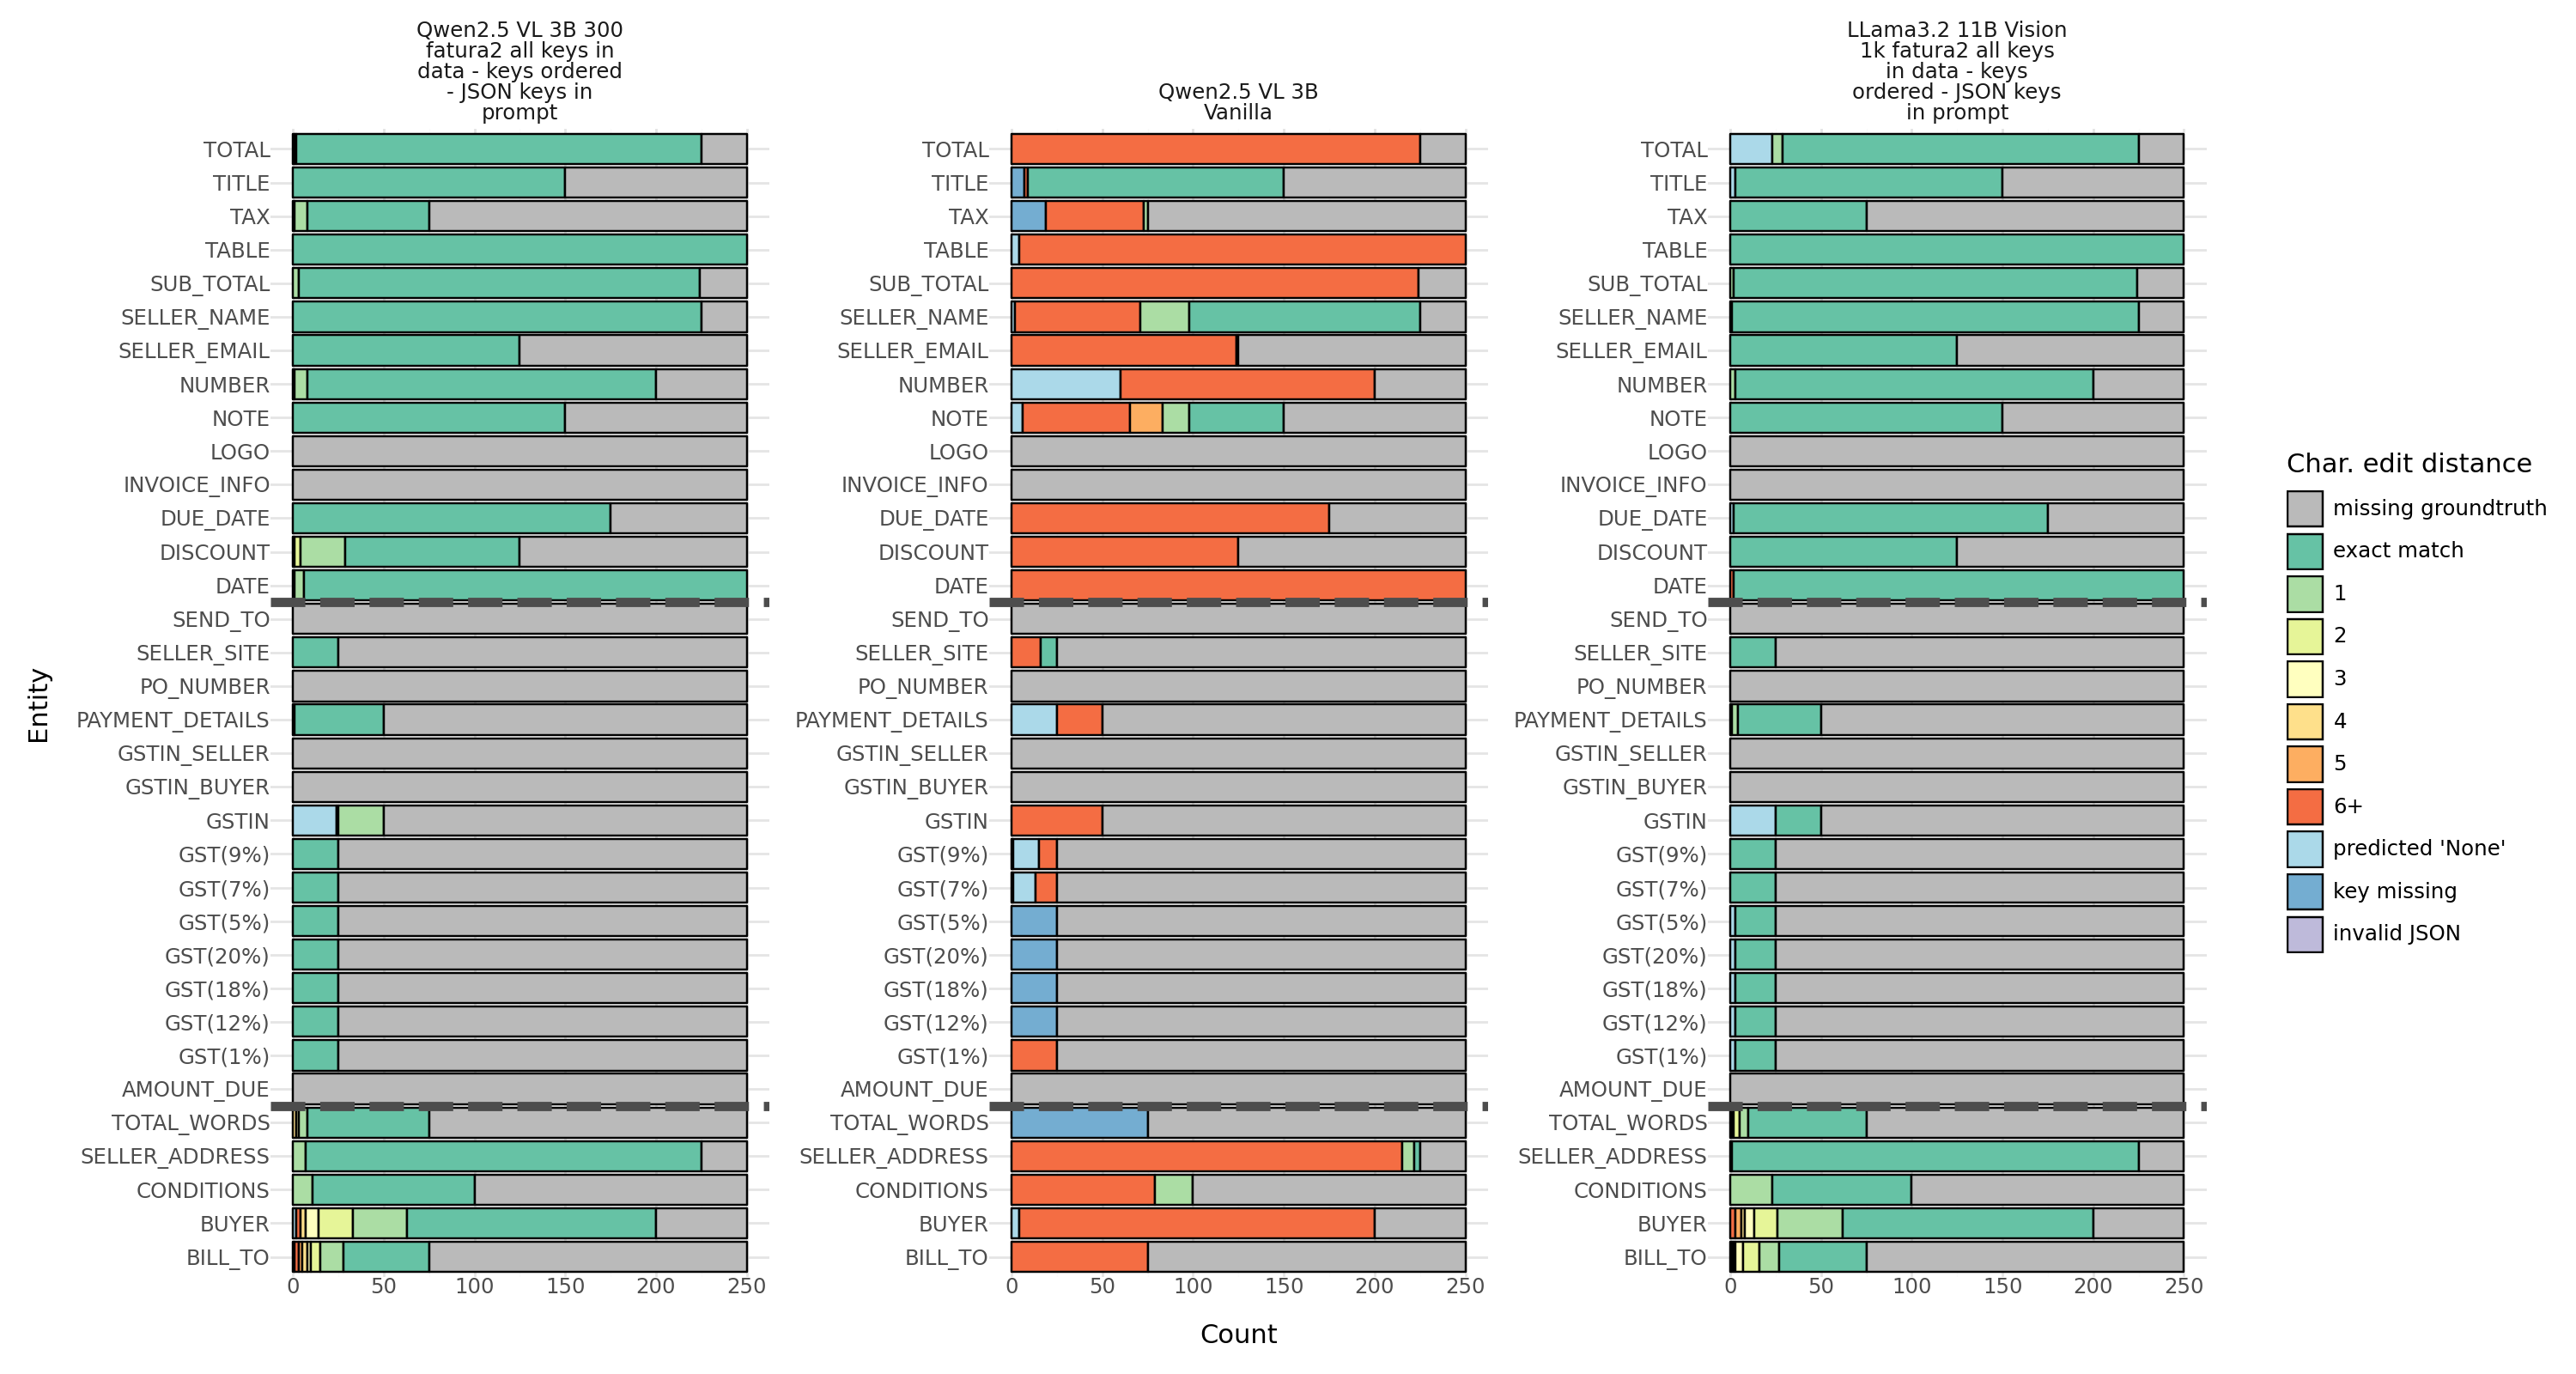

In [25]:
plot = plot_bar_chart_all_entities(
    df_sorted, ordered_values, width=15, height=8, geom_vlines=feature_class_lines
)
display(Markdown(f"### All Entities"))
plot.show()

In [26]:
from utils.entities import FeatureCategory
feature_to_remove = FeatureCategory.MISSING_GROUND_TRUTH
remaining_columns = df_entities[df_entities["entity_type"] != feature_to_remove]
remaining_columns.reset_index(inplace=True)

ordered_values = list(remaining_columns["entity"])

df_filtered = df_sorted[df_sorted["entity"].isin(ordered_values)]

change_indices = remaining_columns.index[
    remaining_columns["entity_type"] != remaining_columns["entity_type"].shift()
].tolist()
feature_class_lines = [index + 0.5 for index in change_indices[1:]]

### Relevant Entities

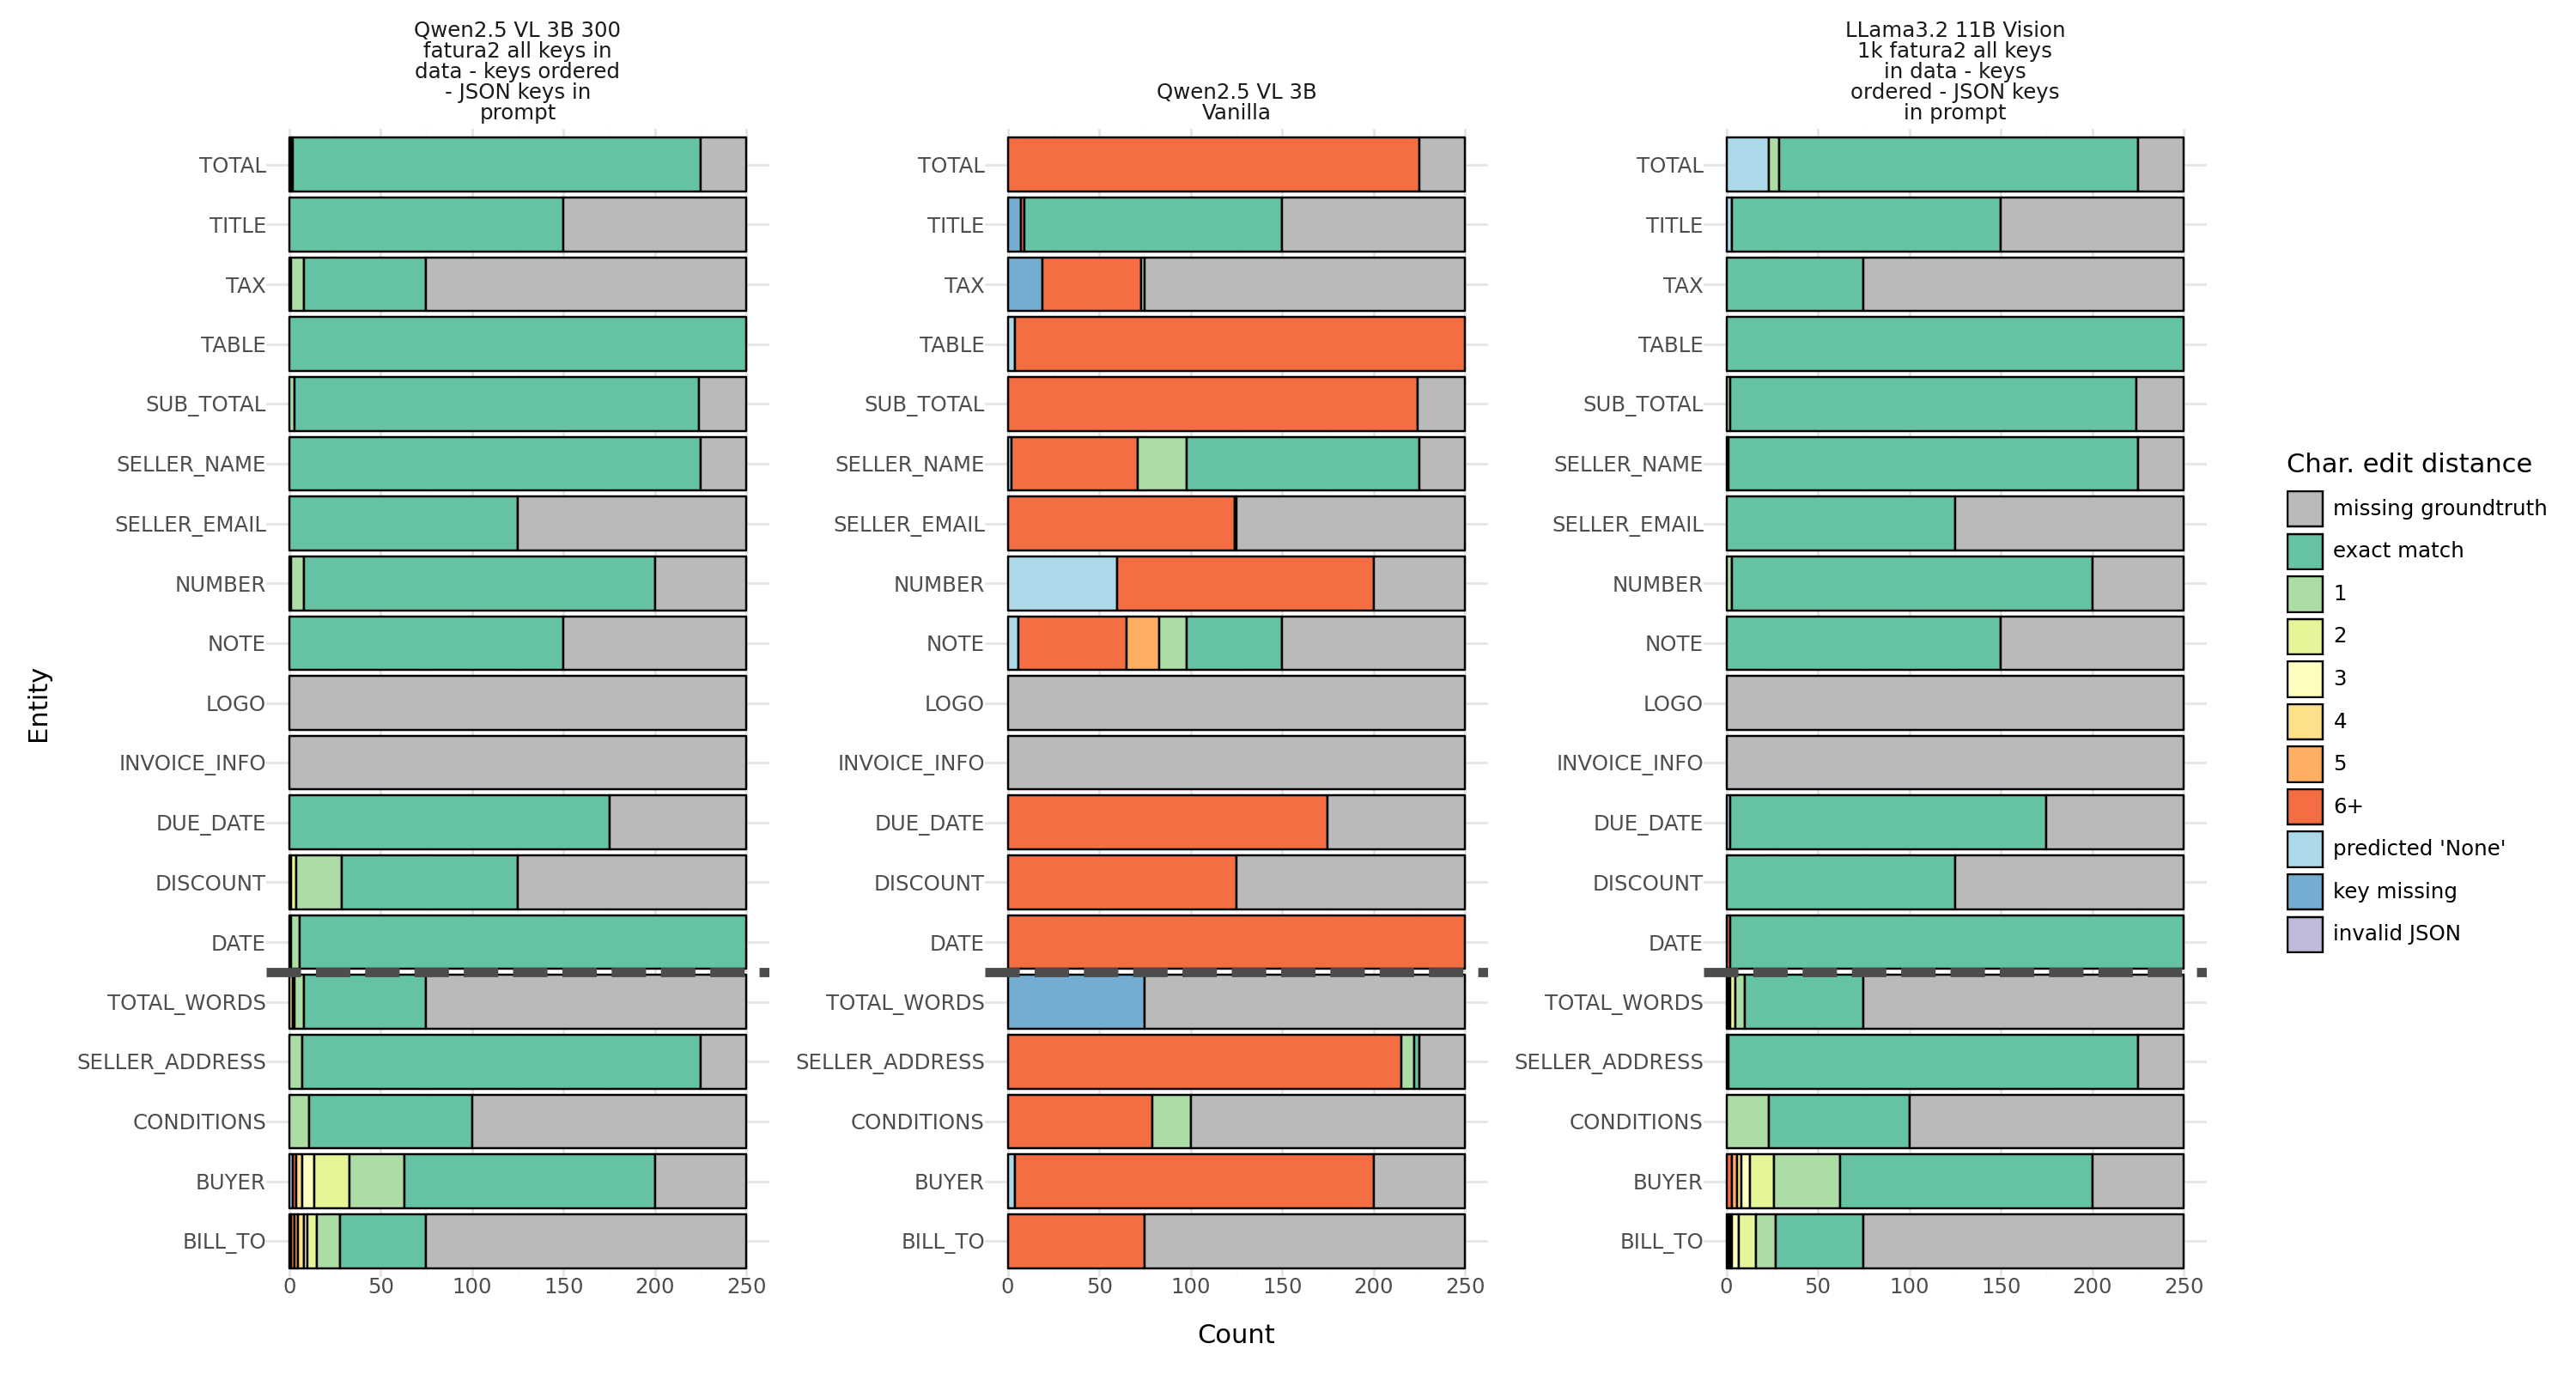

In [27]:
plot = plot_bar_chart_all_entities(
    df_filtered, ordered_values, width=15, height=8, geom_vlines=feature_class_lines
)
display(Markdown(f"### Relevant Entities"))
plot.show()

In [28]:
# plot.save('./images/fatura2-evaluation-heatmap-char-edit-distance.png', dpi=300, facecolor='white')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./images/fatura2-evaluation-heatmap-char-edit-distance.png


# Model Performance Comparison
## Calculate Metrics for Comparison

In [29]:
# setup metrics
import evaluate
from cer import calculate_cer

# eval_metrics = ["exact_match", "character"]
eval_metrics = ["exact_match", "character", "bleu", "rouge"]
evaluations = [evaluate.load(metric) for metric in eval_metrics]

2025-03-21 11:43:02.241921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 11:43:02.291439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 11:43:02.307317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 11:43:02.558841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def calculate_metrics(references, predictions):
    metrics = []
    for metric in evaluations:
        res = metric.compute(predictions=predictions, references=references)
        metrics.append(res)

    results = {}
    for metric in metrics:
        for key, value in metric.items():
            results[key] = value
    return results


df_eval = df_filtered.groupby(["model", "model_name", "pretty_name", "entity"]).apply(
    lambda x: calculate_metrics(
        x["label_val"].astype(str).values, x["response_val"].astype(str).values
    )
)

df_eval = df_eval.reset_index()
# Convert the dictionary column into separate columns
df_eval = pd.concat([df_eval, df_eval[0].apply(pd.Series)], axis=1)
df_eval = df_eval.drop(0, axis=1)

/tmp/ipykernel_25438/1292378320.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


## Exact Match Evaluation

In [31]:
#df_eval

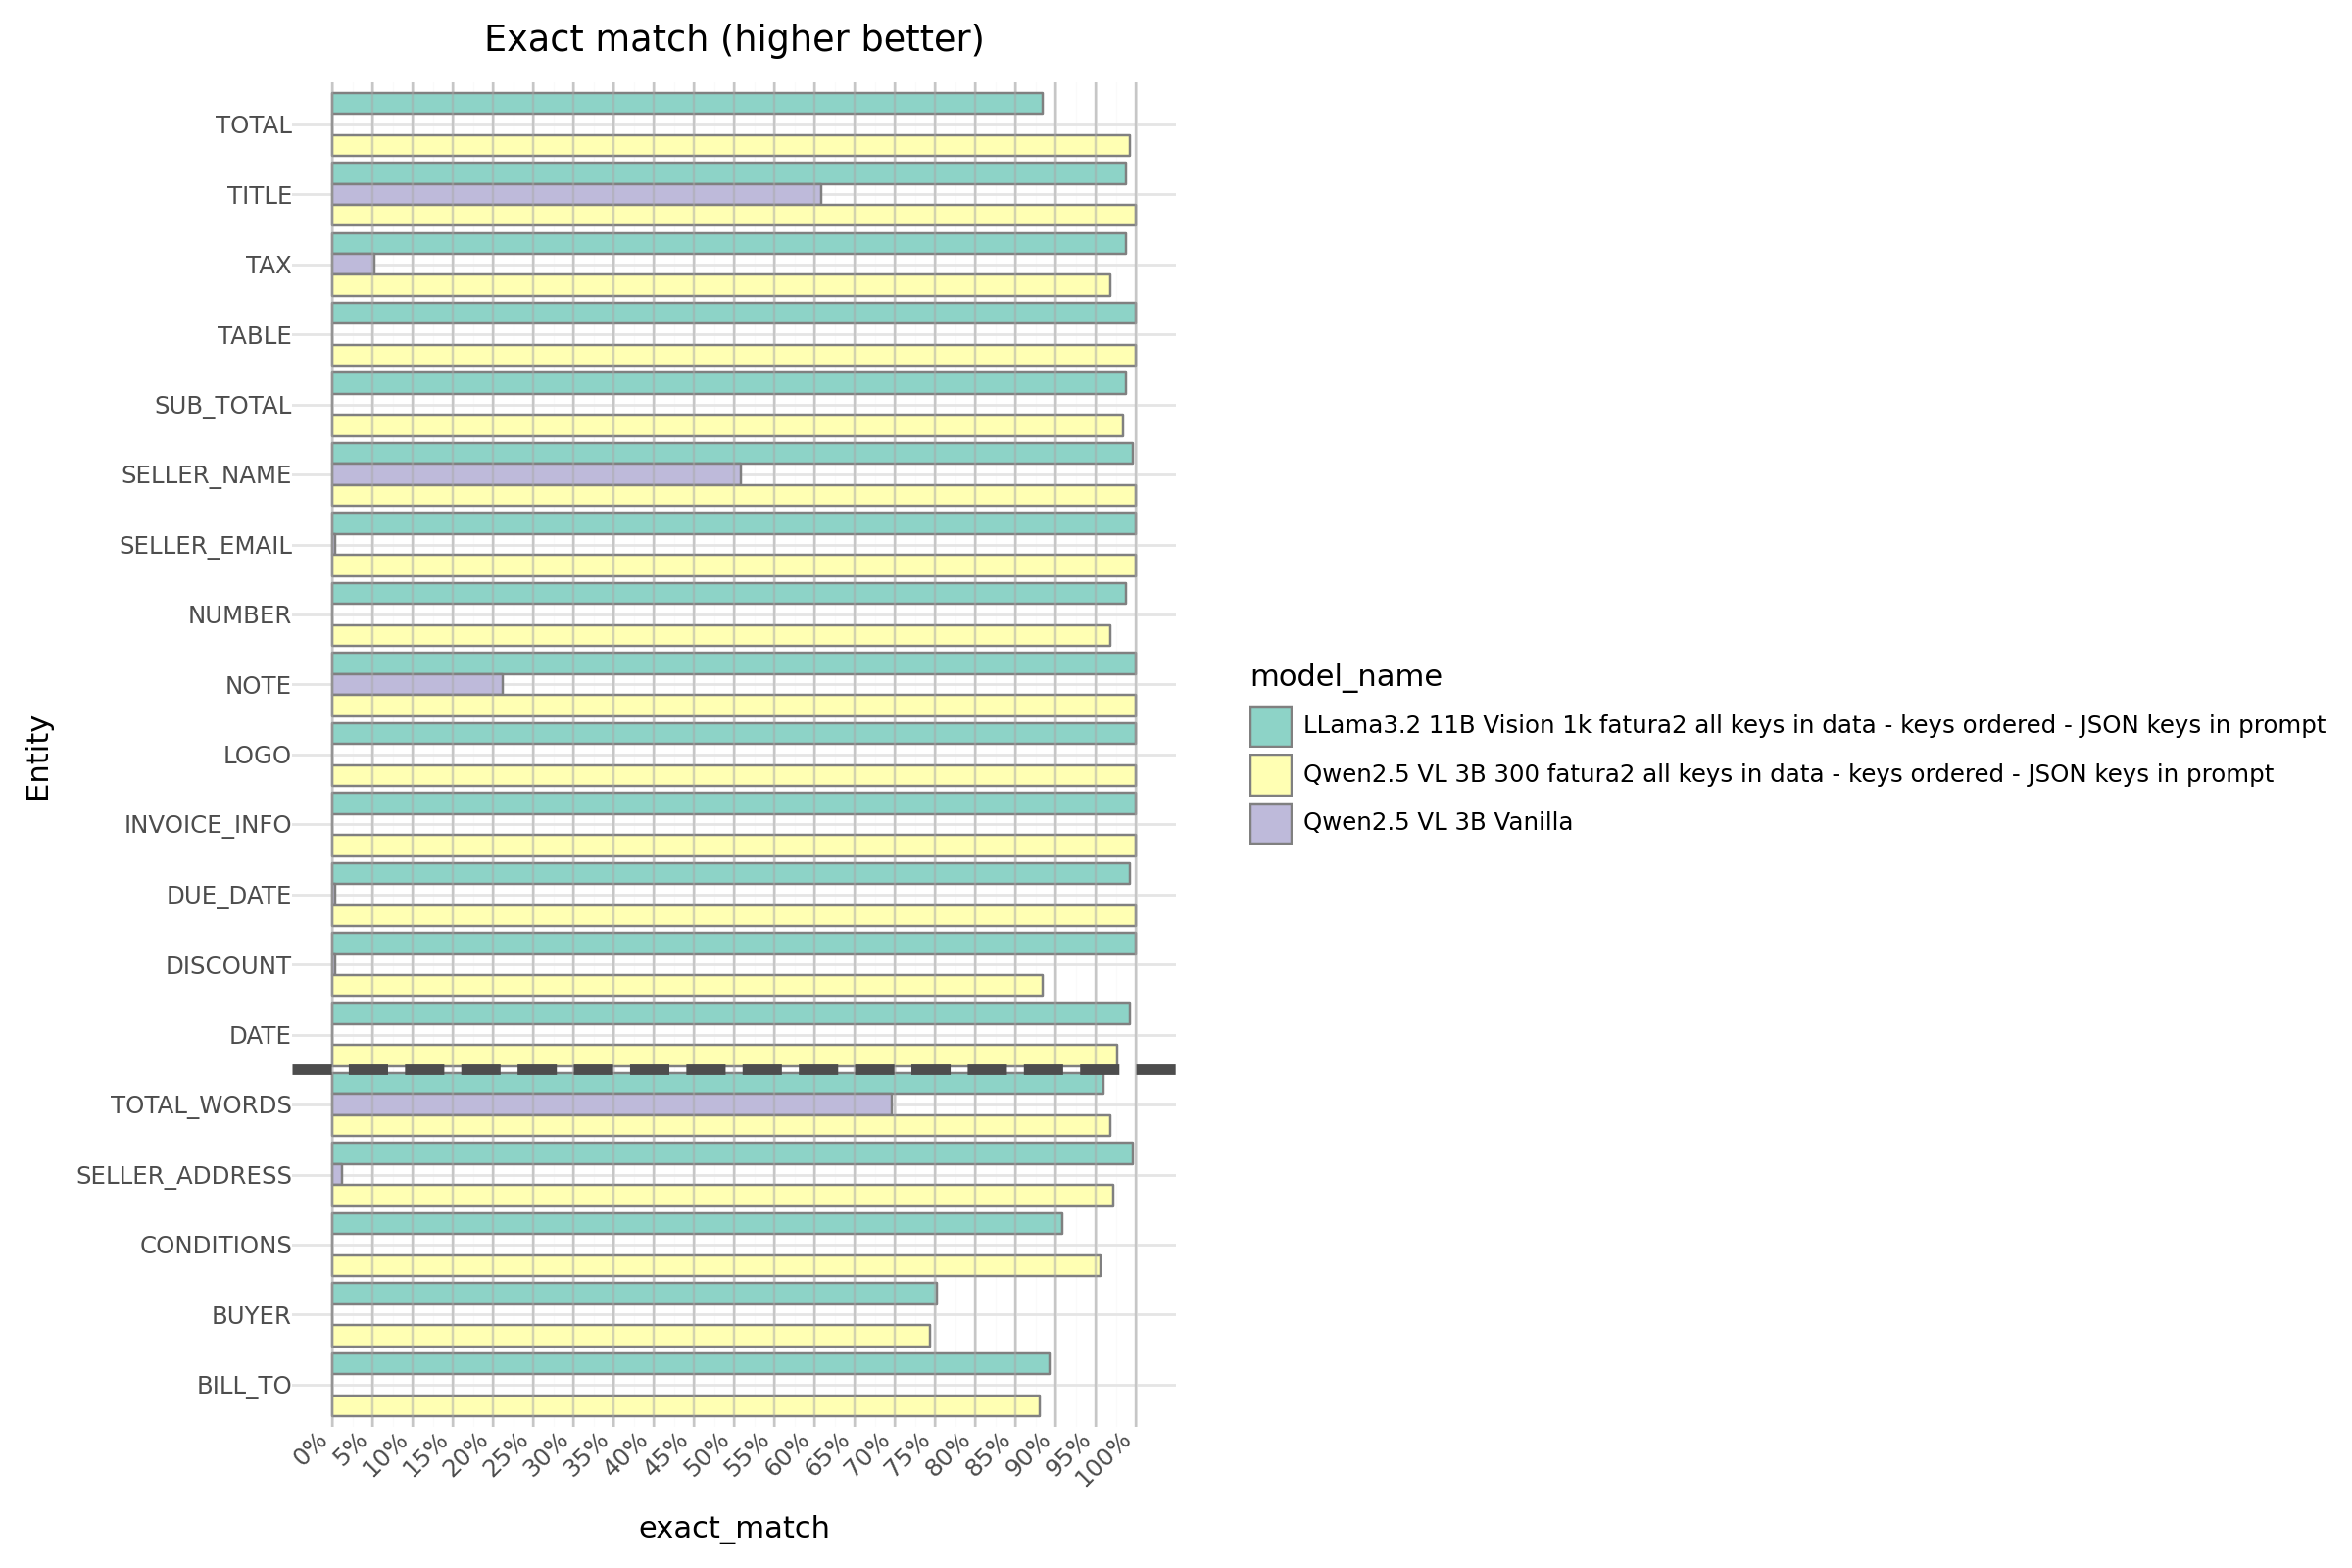

In [32]:
import pandas as pd
from plotnine import *


# Create the stacked bar chart
plot = (
    ggplot(df_eval, aes(x="entity", y="exact_match", group="model", fill="pretty_name"))
    + geom_bar(stat="identity", position="dodge", colour="gray")
    + labs(
        title="Exact match (higher better)",
        x="Entity",
        y="exact_match",
        fill="model_name",
    )
    + coord_flip()
    # + scale_fill_manual(values=custom_colors, labels=fact_name)
    + scale_fill_brewer(type="qual", palette="Set3")
    + theme_minimal()
    + theme(figure_size=(12, 8))
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_y_continuous(
        breaks=[x / 100.0 for x in range(0, 101, 5)],
        labels=[f"{i}%" for i in range(0, 101, 5)],
    )
    + geom_hline(
        yintercept=[x / 100.0 for x in range(0, 101, 5)],
        color="darkgray",
        size=0.5,
        alpha=0.5,
    )
    + geom_vline(
        xintercept=feature_class_lines, linetype="dashed", color="#4d4d4d", size=2.2
    )
    + scale_x_discrete(limits=ordered_values)  # ordering
)
plot

In [34]:
# plot.save('./images/fatura2-evaluation-exact-match.png', dpi=300, facecolor='white')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./images/fatura2-evaluation-exact-match.png


## Character Error Correction - cer_score

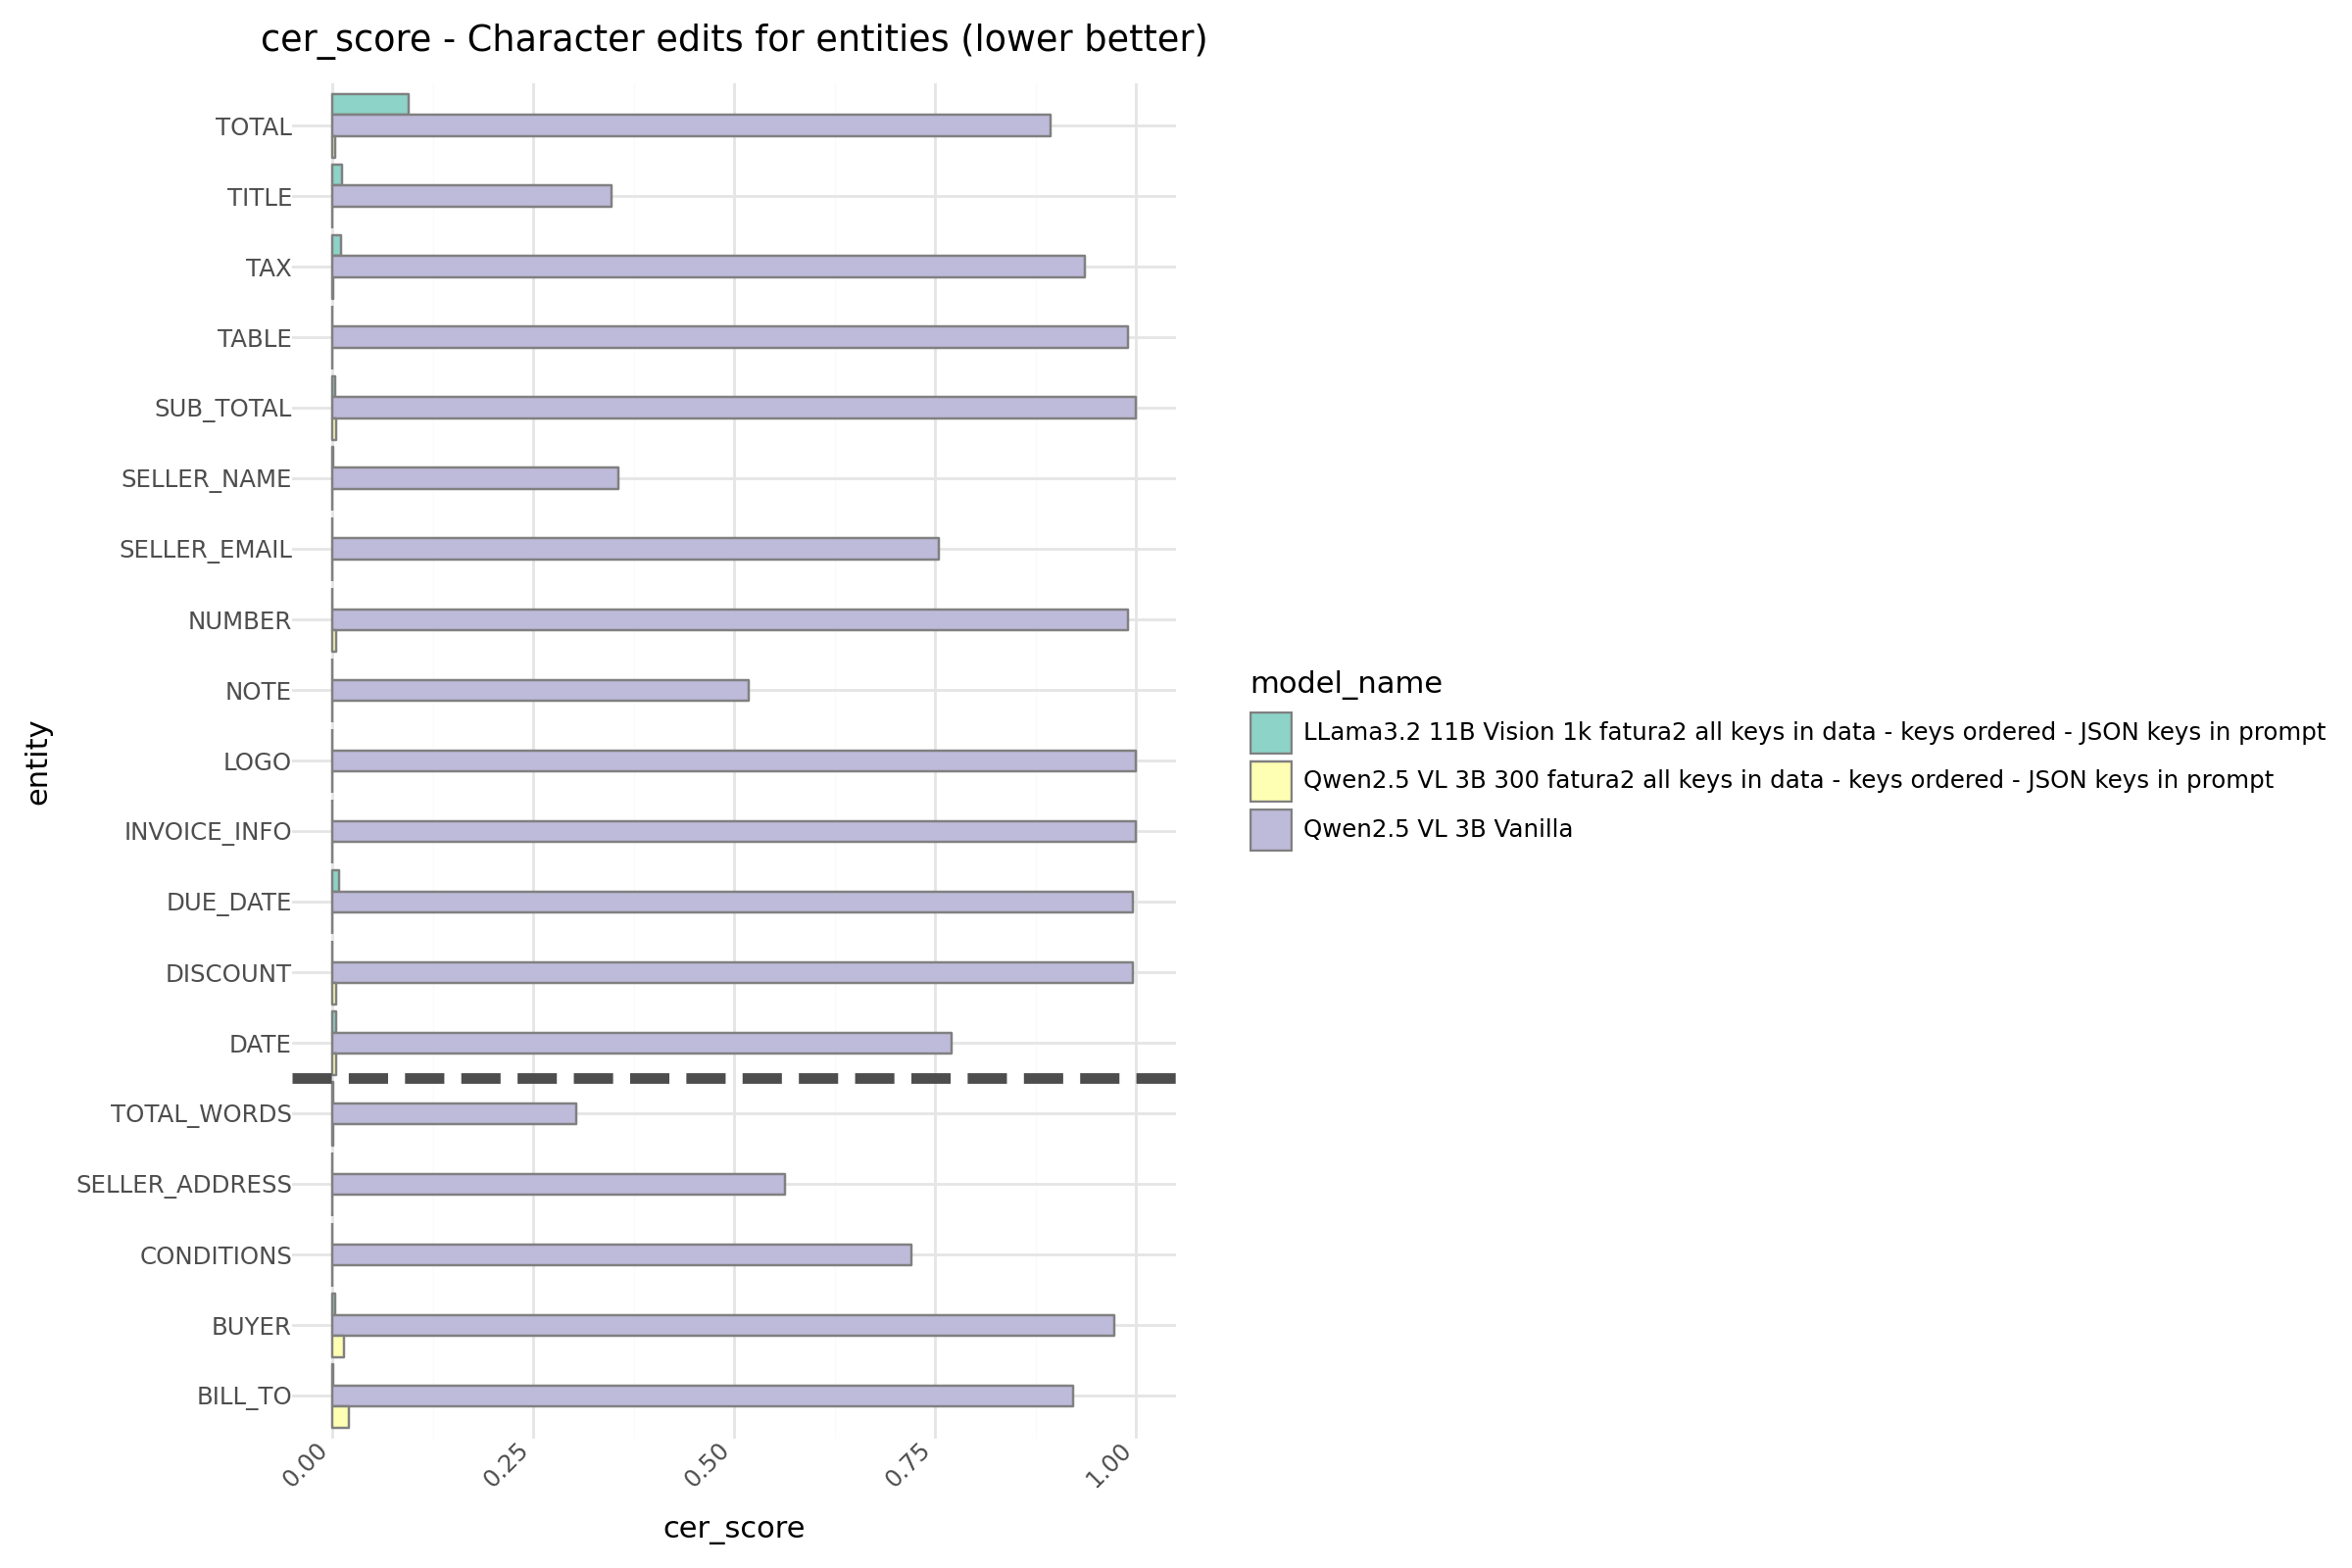

In [35]:
import pandas as pd
from plotnine import *

# Create the stacked bar chart
(
    ggplot(df_eval, aes(x="entity", y="cer_score", group="model", fill="pretty_name"))
    + geom_bar(stat="identity", position="dodge", color="gray")
    + labs(
        title="cer_score - Character edits for entities (lower better)",
        fill="model_name",
    )
    + coord_flip()
    # + scale_fill_manual(values=custom_colors, labels=fact_name)
    + scale_fill_brewer(type="qual", palette="Set3")
    + theme_minimal()
    + theme(figure_size=(12, 8))
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + geom_vline(
        xintercept=feature_class_lines, linetype="dashed", color="#4d4d4d", size=2.2
    )
    + scale_x_discrete(limits=ordered_values)  # ordering
)

## Aggregate Model Metrics in Table View

In [36]:
# Extract exact match entities
exact_match_feature = FeatureCategory.SHORT_TEXT
exact_match_columns = df_entities[df_entities["entity_type"] == exact_match_feature]

exact_match_entities = list(exact_match_columns["entity"])
exact_match_df = df_eval[df_eval["entity"].isin(exact_match_entities)]


# Calculate accuracy for each model as the mean of exact match scores
exact_aggregate = (
    exact_match_df.groupby(["model", "model_name", "pretty_name"])
    .agg({"exact_match": "mean","cer_score":"mean"})
    .reset_index()
)

exact_aggregate.columns = ["model", "model_name", "pretty_name","accuracy (exact match)","cer_score"]
exact_aggregate

,model,model_name,pretty_name,accuracy (exact match),cer_score
0,data/results/infer-json-8xlarge-finetune-qwen2-5-vl--2025-03-21-10-27-17-087/results,Qwen/Qwen2.5-VL-3B-Instruct,Qwen2.5 VL 3B 300 fatura2 all keys in data - keys ordered - JSON keys in prompt,0.983714,0.001792
1,data/results/infer-json-Qwen-Qwen2-5-VL-3B-Instruct-2025-03-18-00-36-24-726/results,Qwen/Qwen2.5-VL-3B-Instruct,Qwen2.5 VL 3B Vanilla,0.099429,0.824963
2,data/results/infer-json-finetune-llama-3-2-11b-visio-2025-03-17-22-50-45-144/results,meta-llama/Llama-3.2-11B-Vision-Instruct,LLama3.2 11B Vision 1k fatura2 all keys in data - keys ordered - JSON keys in prompt,0.986857,0.009801


In [37]:
# Define the entities of type "ngram"
summary_feature = FeatureCategory.LONG_TEXT
summary_columns = df_entities[df_entities["entity_type"] == summary_feature]
ngram_entities = list(summary_columns["entity"])

# Filter the DataFrame for ngram entities
ngram_df = df_eval[df_eval["entity"].isin(ngram_entities)]

# Group by 'model' and 'model_name' and calculate the mean of the ROUGE scores for ngram entities
ngram_rouge_scores = (
    ngram_df.groupby(["model","pretty_name"])
    .agg({"rouge1": "mean", "rouge2": "mean", "rougeL": "mean", "rougeLsum": "mean"})
    .reset_index()
)

In [38]:
# Merge the ROUGE score DataFrame with the accuracy DataFrame on 'model' and 'model_name'
aggregated_metrics = ngram_rouge_scores.merge(
    exact_aggregate, on=["model","pretty_name"], how="inner"
)

In [39]:
metric_columns = ["rouge1", "rouge2", "rougeL", "rougeLsum", "accuracy (exact match)"]

In [40]:
aggregated_metrics[metric_columns] = aggregated_metrics[metric_columns].round(2)

In [41]:
aggregated_metrics["model"] = aggregated_metrics["model"].apply(
    lambda model: model.replace("\n", " ")
)

In [42]:
import numpy as np

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
    
aggregated_metrics.style.apply(highlight_max, props='background-color:lightblue', axis=0)

slice_ = ['rouge1','rouge2','rougeL','rougeLsum', 'accuracy (exact match)']
aggregated_metrics.style.apply(highlight_max, props='background-color:#99d594;', axis=0, subset=slice_)\
         .apply(highlight_min, props='background-color:#99d594;', axis=0, subset=['cer_score'])


,model,pretty_name,rouge1,rouge2,rougeL,rougeLsum,model_name,accuracy (exact match),cer_score
0,data/results/infer-json-8xlarge-finetune-qwen2-5-vl--2025-03-21-10-27-17-087/results,Qwen2.5 VL 3B 300 fatura2 all keys in data - keys ordered - JSON keys in prompt,0.990000,0.530000,0.990000,0.990000,Qwen/Qwen2.5-VL-3B-Instruct,0.980000,0.001792
1,data/results/infer-json-Qwen-Qwen2-5-VL-3B-Instruct-2025-03-18-00-36-24-726/results,Qwen2.5 VL 3B Vanilla,0.340000,0.170000,0.340000,0.340000,Qwen/Qwen2.5-VL-3B-Instruct,0.100000,0.824963
2,data/results/infer-json-finetune-llama-3-2-11b-visio-2025-03-17-22-50-45-144/results,LLama3.2 11B Vision 1k fatura2 all keys in data - keys ordered - JSON keys in prompt,1.000000,0.530000,1.000000,1.000000,meta-llama/Llama-3.2-11B-Vision-Instruct,0.990000,0.009801


In [43]:
# markdown_table = aggregated_metrics.to_markdown()

# # Print the markdown table
# print(markdown_table)

|    | model                                                                                | pretty_name                                                                          |   rouge1 |   rouge2 |   rougeL |   rougeLsum | model_name                               |   accuracy (exact match) |   cer_score |
|---:|:-------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------|---------:|---------:|---------:|------------:|:-----------------------------------------|-------------------------:|------------:|
|  0 | data/results/infer-json-8xlarge-finetune-qwen2-5-vl--2025-03-21-10-27-17-087/results | Qwen2.5 VL 3B 300 fatura2 all keys in data - keys ordered - JSON keys in prompt      |     0.99 |     0.53 |     0.99 |        0.99 | Qwen/Qwen2.5-VL-3B-Instruct              |                     0.98 |  0.00179195 |
|  1 | data/results/infer-json-Qwen-Qwen2-5-VL-3B-Instruct-2025-

# Conclusion

We analyzed the inference results for our invoice dataset. Then we visualized the results for each entity in an edit distance heatmap. Finally, we aggregated multiple metrics and compared the final metrics across different runs and models.

## Main learnings:

Constrained Decoding works, but the model can sometimes get into a recursive loop and exceed the max_token parameter during generation. The resulting output might thus not be a valid JSON. 
We perform the following steps to improve the results and resolve the invalid JSON challenges:

* We removed fields with poor data quality, like the `Other` field in this dataset.
* We made sure that each key of the unified set of target JSON keys is contained in the target JSON to be learned by the model. In cases with no ground truth, None is used as prediction value.
* We made sure that the keys have the same ordering in the target JSON.
* We added the expected target keys as a list to the prompt for training.

These methods together allow us to achieve 98% accuracy (exact match) with a small Qwen2.5 VL 3B model and 300 used samples for training.

## Next steps

You can choose the best model for your use case and proceed with the [deployment of the selected model](06_deploy_model_endpoint.ipynb).